# 3. Detection algorithm: Weight Statistics
... Implementation in numpy

Author: Javier Sales-Ortiz

Date: Nov, 2022

CMPUT 644 Final project

In [76]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)

## Questions

* Are the distances calculated with biases or only the weights? Both, treat all parameters the same
* Do it on the weights, not on the updates. But at the end of the dat it can be itnerchangeable

In [148]:
#w1 = np.random.normal(loc =(0,0), scale = 1.0, size=(30, 2)).T
#w2 = np.random.normal(loc =(2,2), scale = 1.0, size=(30, 2)).T
#w3 = np.random.normal(loc =(-2,2), scale = 1.0, size=(30, 2)).T
#w4 = np.random.normal(loc =(10,10), scale = 1.0, size=(30, 2)).T
w1 = np.array([0,0])
w2 = np.array([0.5,0.5])
w3 = np.array([1,1])
w4 = np.array([4,4])
WL = [w1, w2, w3, w4]
print(w1.shape, w2.shape)


(2,) (2,)


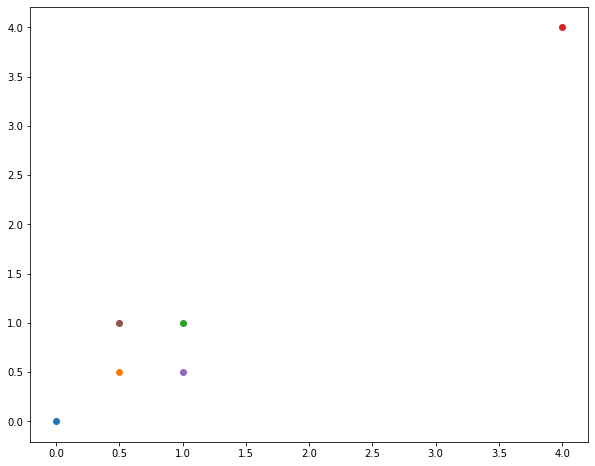

In [149]:
fig1 = plt.figure(figsize=(10,8))
ax1 = fig1.add_subplot(1,1,1)

for w in WL:
    ax1.scatter(w[0], w[1])

1. For the malicious agent we compute:

$R_m = [\min_{i \in [k] \backslash m} d(\mathbb{\delta}_m^t, \mathbb{\delta}_i^t), \max_{i \in [k] \backslash m} d(\mathbb{\delta}_m^t, \mathbb{\delta}_i^t)]$

2. Define values:

$R_{\min,[k] \backslash m}^l$ The minimum lower bound of the range for all other agents

$R_{\max,[k] \backslash m}^u$ The maximum upper bound of the range for all other agents

3. For the malicious agent not to be flagged, we need:

$\max \{|R_m^u-R_{min, [k] \backslash m}^l|, |R_{m}^l - R_{max, [k]\backslash m}^u| \} < \kappa_t$

I have observed that 3. doesn't work, so my proposed fix is:

$\max \{|R_m^l-R_{min, [k] \backslash m}^l|, |R_{m}^u - R_{max, [k]\backslash m}^u| \} < \kappa_t$

In [150]:
def weight_update_statistics(WL, kappa=2, fix = False):
    n = len(WL)
    dist_matrix = np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            if i == j:
                dist_matrix[i,j] = np.NaN
            else:
                dist_matrix[i,j] = dist_matrix[j,i] = np.linalg.norm(WL[i] - WL[j])
    

    #dist_matrix = np.array([[np.nan, 0.5, 1.5, 6.0], 
    #                        [0.5, np.nan, 1.0, 5.0],
    #                        [1.5, 1.0, np.nan, 2.0],
    #                        [6.0, 5.0, 2.0, np.nan]])
    print(dist_matrix)
    
    detect_arr = np.ones(n)
    for m in range(n):
        my_min = np.nanmin(dist_matrix[m,:])
        my_max = np.nanmax(dist_matrix[m,:])
        they_arr = np.delete(np.delete(dist_matrix, m, 0), m, 1).flatten()
        their_min = np.nanmin(they_arr)
        their_max = np.nanmax(they_arr)
        #if fix:
        #    print(f"Agent {m}: Rm [{my_min:.2f}, {my_max:.2f}], R_k\m [{their_min:.2f}, {their_max:.2f}] [|R(l,m)-R(l,k\\m)|, |R(u,m)-R(u,k\\m)|] {abs(my_min-their_min):.2f}, {abs(my_max-their_max):.2f}")
        #    R_max = max(abs(my_min - their_min), abs(my_max-their_max))
        #else:
        print(f"Agent {m}: Rm [{my_min:.2f}, {my_max:.2f}], R_k\m [{their_min:.2f}, {their_max:.2f}] [|R(l,m)-R(u,k\\m)|, |R(u,m)-R(l,k\\m)|] {abs(my_min-their_max):.2f}, {abs(my_max-their_min):.2f}")
        R_max = max(abs(my_max - their_min), abs(my_min-their_max))
        if R_max < kappa:
            detect_arr[m] = 0
    return detect_arr


    
    

In [151]:
weight_update_statistics(WL, fix=True)

[[   nan 0.7071 1.4142 5.6569 1.118  1.118 ]
 [0.7071    nan 0.7071 4.9497 0.5    0.5   ]
 [1.4142 0.7071    nan 4.2426 0.5    0.5   ]
 [5.6569 4.9497 4.2426    nan 4.6098 4.6098]
 [1.118  0.5    0.5    4.6098    nan 0.7071]
 [1.118  0.5    0.5    4.6098 0.7071    nan]]
Agent 0: Rm [0.71, 5.66], R_k\m [0.50, 4.95] [|R(l,m)-R(l,k\m)|, |R(u,m)-R(u,k\m)|] 0.21, 0.71
Agent 1: Rm [0.50, 4.95], R_k\m [0.50, 5.66] [|R(l,m)-R(l,k\m)|, |R(u,m)-R(u,k\m)|] 0.00, 0.71
Agent 2: Rm [0.50, 4.24], R_k\m [0.50, 5.66] [|R(l,m)-R(l,k\m)|, |R(u,m)-R(u,k\m)|] 0.00, 1.41
Agent 3: Rm [4.24, 5.66], R_k\m [0.50, 1.41] [|R(l,m)-R(l,k\m)|, |R(u,m)-R(u,k\m)|] 3.74, 4.24
Agent 4: Rm [0.50, 4.61], R_k\m [0.50, 5.66] [|R(l,m)-R(l,k\m)|, |R(u,m)-R(u,k\m)|] 0.00, 1.05
Agent 5: Rm [0.50, 4.61], R_k\m [0.50, 5.66] [|R(l,m)-R(l,k\m)|, |R(u,m)-R(u,k\m)|] 0.00, 1.05


array([0., 0., 0., 1., 0., 0.])

In [90]:
m = 0
np.delete(np.delete(dist_matrix, m, 0), m, 1)

array([   nan, 1.4142, 3.6056, 1.4142,    nan, 3.6056, 3.6056, 3.6056,
          nan])

In [85]:
np.linalg.norm(WL[0]-WL[1])

2.23606797749979